In [1]:
from sympy.combinatorics import *
from itertools import combinations
from sympy.interactive import init_printing

from tqdm.notebook import tqdm

from math import factorial
import numpy as np

import pickle

init_printing(perm_cyclic=True, pretty_print=False) #prints permutations in compact notation
perm_type = permutations.Permutation

# Code base to allow computations in A(d)

In [2]:
def gen_ctype(l: dict,n: int):
    '''
    Input:
        l - cycle decompostion as a dictionary including 1 cycles. e.g. {1:2, 2:1} is a transposition in S_4
        n - specifies order of symmetric group
    Output:
        Generates all permutations of specified cycletype as a list
    '''
    
    has_to_be_partition = 0
    for key, value in l.items():
        has_to_be_partition = has_to_be_partition + key*value
    if has_to_be_partition < n:
        print("Invalid cycle type format.")
    else:
        list_with_cycle_type = []
        
        #run through all permutations and append them if they have the correct cycletype
        for i in list(symmetric(n)): 
            if i.cycle_structure == l:
                list_with_cycle_type.append(i)            
        return list_with_cycle_type
    
g2 = gen_ctype({1:2,2:1},4) #An example of all permutations with cycletype 2 (transpositions) in S_4
g2

[(2 3), (3)(1 2), (1 3), (3)(0 1), (3)(0 2), (0 3)]

In [3]:
def gen_all(d):
    ''' Input: non-negative interger
        Output: Dictionary of elements in the symmetric group with key being cycle type and value all permutations in S(d) with
        that cycle type.
    '''
    answer = {}
    
    for i in tqdm(symmetric(d), total = factorial(d)):
        C = ctype(i)
        if C in answer.keys():
            (answer[C]).append(i)
        else:
            answer[C] = [i]
    answer.pop((d,),None)
    return answer


In [4]:
def norm(p, cycle_dict = None):
    '''
    Input: permutation p, optionally the cycle structure of p.
    Output: The norm of p
    '''
    #If the cycle type of p is already computed we can reuse the result.
    if cycle_dict == None:
        cycle_dict = p.cycle_structure
    sum_of_lengths = 0
    num_cycles = 0
    
    #We use the formula N(sigma) = d-l if sigma has cyclestructure C_1C_2...C_l 
    for key, value in cycle_dict.items():
        sum_of_lengths += key*value
        num_cycles += value
    return sum_of_lengths-num_cycles

In [5]:
def norm2(p_tuple):
    #Computes norm from cyclestructure written as a tuple
    ans = 0
    for i,p in enumerate(p_tuple):
        ans += i*p
    return ans

In [6]:
def norm_check(p,q, norm_sum = None):
    '''
    Input: Permutations p and q, optionally the sum of their norms.
    Output: True if N(pq) = N(p) + N(q), otherwise False.
    '''
    if norm_sum == None:
        norm_sum = norm(p) + norm(q)
    p_trans = set(p.transpositions())
    q_trans = set(q.transpositions())
    
    if p_trans.intersection(q_trans) == set([]):
        return norm(p*q)==norm_sum
    return False

In [7]:
def Aprod(p_list, q_list, norm_sum = None):
    '''
    Input:
        - p_list and q_list, both lists of permutations corresponding to a conjugacy class in S_n
        - The sum of the norm of the conjugacy classes (optional)
    Output:
        - The product of the two conjugacy classes according to A(d)
    '''
    if norm_sum:
        return [s*t for s in p_list for t in q_list if norm_check(s,t,norm_sum)]
    return [s*t for s in p_list for t in q_list if norm_check(s,t)]

# Generate powers of g2, as 
g2_square = Aprod(g2,g2,2)
g2_cube = Aprod(g2,g2_square,3)
g2_square[0:5]

[(1 2 3), (1 3 2), (0 1)(2 3), (0 2 3), (0 3 2)]

In [8]:
def ctype(p):
    '''
    Input:
        Sympy permutation
    Output:
        Gives cycletype of permutation as a tuple with i'th coordinate being multiplicity of i-cycles.
    '''
    d = p.cycle_structure
    max_val = max(d.keys())
    L = []
    for i in range(1,max_val+1):
        if i in list(d.keys()):
            L.append(d[i])
        else:
            L.append(0)
    return tuple(L)

ctype(Permutation(3)(1,3)) # has 2 1-cycles (0 and 2) and one 2-cycle

(2, 1)

In [9]:
def decompose(plist: list, progressbar=True):
    '''
    Input: List of permutations
    Output: Decomposes list by occurences of cycletype
    '''
    cycle_count = {}
    for p in tqdm(plist, disable = progressbar):
        p_type = ctype(p)
        if p_type in list(cycle_count.keys()):
            cycle_count[p_type] += 1
        else:
            cycle_count[p_type] = 1
    return cycle_count
#Decomposes list of permutations into representatives of the conjugacy class, e.g. (g_2)^2 has 24 3-cycles and 6 2-cycles
print("g2 squared decomp", decompose(g2_square),
      "\n" "g2 cubed decomp", decompose(g2_cube))

g2 squared decomp {(1, 0, 1): 24, (0, 2): 6} 
g2 cubed decomp {(0, 0, 0, 1): 96}


In [10]:
def num_ctype(ctuple):
    '''
    Input: cycle type as a tuple
    Output: number of permutations with given cycle type using 
    '''
    n = sum((i+1)*ctuple[i] for i in range(len(ctuple)))
    numerator = factorial(n)
    denominator = 1
    for i in range(len(ctuple)):
        denominator *= ((i+1)**ctuple[i]) * factorial(ctuple[i])
    return numerator // denominator

num_ctype((2,1)) #Size of the conjugacy class of 2-cycles in d = 2*1+1*2 = 4

6

In [11]:
def to_string(d):
    if type(d) == dict:
        s = ""
        for key, value in d.items():
            s += str(value) + "*" + "g_"+ to_string(key) + "  +  "
        return s[0:-3]
    s = ""
    for i,k in enumerate(d):
        if i!=0 and k!= 0:
            s+= str(i+1) + "^" + str(k) + ","
    return s[0:-1]

In [12]:
def decompose2(plist, string_output = False):
    '''
    Input: list of permutations
    Output: decomposition according to A(d)
    '''
    d = decompose(plist)
    for i in d.keys():
        d[i] //= num_ctype(i)
        
    if string_output:
        return to_string(d)
    return d
#Same as decompose, but divided by the size of the conjugacy class, so (g_2)^2 = 3g_3+2g_{2^2}. This recovers the results from
#project catalgoue
print("g2 square", decompose2(g2_square), 
      "\n" "g2 cube", decompose2(g2_cube))

g2 square {(1, 0, 1): 3, (0, 2): 2} 
g2 cube {(0, 0, 0, 1): 16}


### Experiments with the g_{2^i} generating set for d=6

In [32]:
d = 6
g2 = gen_ctype({1:(d-2), 2:1}, d) #Generates all the transpositions in S_d, here d=6, giving rise to the element g_2 in A(6).

g2_powers = [Aprod(g2,g2,2)] #Computes (g_2)^2

for i in tqdm(range(3,3+3)): #Recursively computes the powers (g_2)^3 to (g_2)^6
    g2_powers.append(Aprod(g2,g2_powers[-1],i))

  0%|          | 0/3 [00:00<?, ?it/s]

In [33]:
g2_powers_decomp = []
for i in tqdm(g2_powers): #Decomposes the powers into basis elements of A(6), so e.g. (g_2)^3 = 16g_4+8g_{2,3}+6g_{2^3}
    g2_powers_decomp.append(decompose2(i))
    print(g2_powers_decomp[-1])

  0%|          | 0/4 [00:00<?, ?it/s]

{(3, 0, 1): 3, (2, 2): 2}
{(2, 0, 0, 1): 16, (1, 1, 1): 9, (0, 3): 6}
{(1, 0, 0, 0, 1): 125, (0, 1, 0, 1): 64, (0, 0, 2): 54}
{(0, 0, 0, 0, 0, 1): 1296}


# Constructing multiplication tables to investigate relations in A(9)

In [34]:
d=8
basis = gen_all(d)

  0%|          | 0/40320 [00:00<?, ?it/s]

In [35]:
#Give multiplication table of generators, i.e. computing (g_{2^i})(g_{2^j}) for 1<= i,j <= 4.
generators = [basis[(d-2*i,i)] for i in range(1,d//2+1)]
print("Sample permutations from generators:", [g[0] for g in generators])
for i,g1 in tqdm(enumerate(generators)):
    for j,g2 in enumerate(generators[i:]):
        print("basis:",i+1,j+i+1,"Product:",decompose2(Aprod(g1,g2,2*i+j+2),True))

Sample permutations from generators: [Permutation(6, 7), Permutation(4, 5)(6, 7), Permutation(2, 3)(4, 5)(6, 7), Permutation(0, 1)(2, 3)(4, 5)(6, 7)]
basis: 1 1 Product: 3*g_3^1  +  2*g_2^2  
basis: 1 2 Product: 2*g_4^1  +  3*g_2^1,3^1  +  3*g_2^3  
basis: 1 3 Product: 2*g_2^1,4^1  +  3*g_2^2,3^1  +  4*g_2^4  
basis: 1 4 Product: 2*g_2^2,4^1  
basis: 2 2 Product: 5*g_5^1  +  4*g_2^1,4^1  +  9*g_3^2  +  6*g_2^2,3^1  +  6*g_2^4  
basis: 2 3 Product: 3*g_6^1  +  5*g_2^1,5^1  +  6*g_3^1,4^1  +  6*g_2^2,4^1  +  9*g_2^1,3^2  
basis: 2 4 Product: 3*g_2^1,6^1  +  4*g_4^2  
basis: 3 3 Product: 7*g_7^1  +  6*g_2^1,6^1  +  8*g_4^2  +  15*g_3^1,5^1  
basis: 3 4 Product: 4*g_8^1  
basis: 4 4 Product: 


In [36]:
#Multiplication table of g2 with other elements
g2_mult_table = []

for k,v in tqdm(basis.items()):
    s ="g_2 * g_" + to_string(k) + " = "
    s += decompose2(Aprod(basis[(d-2,1)],v, norm2((d-2,1)) + norm2(k)), string_output = True)
    g2_mult_table.append(s)
    print(s)

  0%|          | 0/21 [00:00<?, ?it/s]

g_2 * g_2^1 = 3*g_3^1  +  2*g_2^2  
g_2 * g_3^1 = 4*g_4^1  +  1*g_2^1,3^1  
g_2 * g_2^2 = 2*g_4^1  +  3*g_2^1,3^1  +  3*g_2^3  
g_2 * g_4^1 = 5*g_5^1  +  1*g_2^1,4^1  
g_2 * g_2^1,3^1 = 5*g_5^1  +  4*g_2^1,4^1  +  6*g_3^2  +  2*g_2^2,3^1  
g_2 * g_5^1 = 6*g_6^1  +  1*g_2^1,5^1  
g_2 * g_2^3 = 2*g_2^1,4^1  +  3*g_2^2,3^1  +  4*g_2^4  
g_2 * g_2^1,4^1 = 6*g_6^1  +  5*g_2^1,5^1  +  3*g_3^1,4^1  +  2*g_2^2,4^1  
g_2 * g_3^2 = 3*g_6^1  +  4*g_3^1,4^1  +  1*g_2^1,3^2  
g_2 * g_6^1 = 7*g_7^1  +  1*g_2^1,6^1  
g_2 * g_2^2,3^1 = 5*g_2^1,5^1  +  2*g_3^1,4^1  +  4*g_2^2,4^1  +  6*g_2^1,3^2  
g_2 * g_2^1,5^1 = 7*g_7^1  +  6*g_2^1,6^1  +  3*g_3^1,5^1  
g_2 * g_3^1,4^1 = 7*g_7^1  +  5*g_3^1,5^1  +  8*g_4^2  
g_2 * g_7^1 = 8*g_8^1  
g_2 * g_2^4 = 2*g_2^2,4^1  
g_2 * g_2^2,4^1 = 6*g_2^1,6^1  +  4*g_4^2  
g_2 * g_2^1,3^2 = 3*g_2^1,6^1  +  5*g_3^1,5^1  
g_2 * g_2^1,6^1 = 8*g_8^1  
g_2 * g_3^1,5^1 = 8*g_8^1  
g_2 * g_4^2 = 4*g_8^1  
g_2 * g_8^1 = 


In [ ]:
#Entire multiplication table
mult_table = []

for k1,v1 in tqdm(basis.items()):
    for k2,v2 in basis.items():
        if k1 >= k2:
            n = norm2(k1) + norm2(k2)
            if n < d:
                s = "g_"+to_string(k1) + " * g_" + to_string(k2)
                s += " = " + decompose2(Aprod(v1,v2,n), string_output = True)
                mult_table.append(s)
                print(s)

### Save result as a pickle file

In [ ]:
#with open('g2table.pkl', 'wb') as f:
#    pickle.dump(g2_mult_table, f)

In [ ]:
#with open('prod_obs.pkl', 'wb') as f:
#    pickle.dump(products, f)

In [ ]:
with open('g2table.pkl', 'rb') as f:
    products = pickle.load(f)
for line in products:
    print(line[0:-3])

In [ ]:
for line in products:
    print(line[0],line[1], list(line[2].values()))

# Relations 2.0

In [15]:
f = lambda u, v: Aprod(u,v)
g = lambda u: decompose2(u, string_output = True)

def gen_monoms(d,generators = [], monomials = [], alphabet = "xyzwXYYZW", print_monoms = True):
    if generators == []:
        basis = gen_all(d)
        generators = [basis[(d-2-2*i, i+1)] for i in range(d//2)]
    
    if monomials == []:
        monomials.append((0,[Permutation(d-1)()], ""))
    
    mon = (norm((generators[0])[0]), generators[0], alphabet[0])

    for m in monomials:
        if m[0] + mon[0] < d:
            if m[2] + mon[2] == (d-1)*"x": 
                #This line was added after knowing that x^(d-1) = d^(d-2)
                pass
            else:
                product = f(mon[1],m[1])
                monomials.append((m[0] + mon[0], product, m[2]+mon[2]))
                if print_monoms:
                    print(m[2]+mon[2] + " generated")
    
    if len(generators)==1:
        return monomials
    else:
        return gen_monoms(d, generators[1:], monomials, alphabet[1:], print_monoms)
            
def rel_experiment(d, return_monomials = False, print_output = True):
    monoms = gen_monoms(d,monomials = [], print_monoms = print_output)
    for m in monoms:
        if len(m[2])>1 and print_output:
            print("monomial:", m[2], "decomp:", g(m[1]))
    if return_monomials:
        return(monoms)

In [16]:
rel_experiment(4)


x generated
xx generated
y generated
xy generated
monomial: xx decomp: 3*g_3^1  +  2*g_2^2  
monomial: xy decomp: 2*g_4^1  


# Timing Analyses

In [37]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from timeit import default_timer

import pandas as pd
from pympler import asizeof # pip install pympler

def timing_experiment(max_d = 5):
    df = pd.DataFrame(columns = ["d", "Time","logTime", "logMemory"])   
    for d in range(2,max_d+1):
        start = default_timer()
        M = rel_experiment(int(d), return_monomials = True, print_output = False)
        end = default_timer()
        df = df.append({"d":d, "Time":(end-start), "logTime":np.log(end-start),
                        "logMemory":np.log(asizeof.asizeof(M))},ignore_index=True)
    return df

In [38]:
time_df = timing_experiment(6)
time_df

,d,Time,logTime,logMemory
0,2.0,0.040751,-3.200285,7.063048
1,3.0,0.059827,-2.816293,8.014336
2,4.0,0.085410,-2.460293,10.123105
3,5.0,0.463375,-0.769218,13.448843
4,6.0,30.185010,3.407345,17.420721


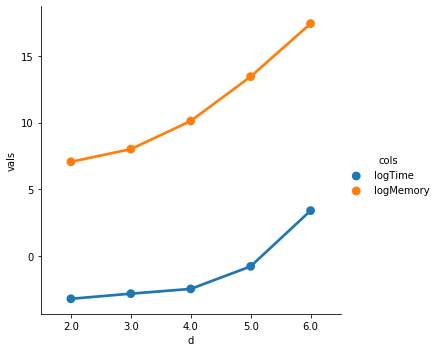

In [39]:
df = time_df[["d","logTime","logMemory"]].melt('d', var_name='cols',  value_name='vals')
g = sns.factorplot(x="d", y="vals", hue='cols', data=df)

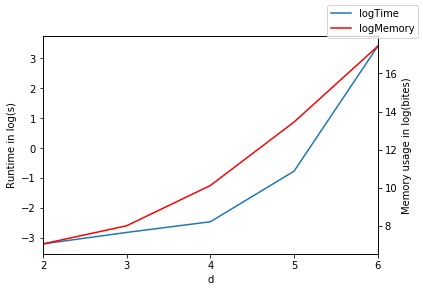

In [55]:
ax = time_df.plot(x="d", y="logTime", legend=False)
plt.ylabel("Runtime in log(s)")
ax2 = ax.twinx()
time_df.plot(x="d", y="logMemory", ax=ax2, legend=False, color="r")
ax.figure.legend()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("d")
plt.ylabel("Memory usage in log(bites)")
plt.savefig("TimeAndMemory.pdf")